# Problem Statement
Given a dataset of the daily car count in a parking lot, a corresponding weather index and a indicator of sky conditions (clear / cloudy) along with the corresponding day of the week, we need to provide a daily forecast for the car count for the next month.

## Approach
Given any problem, the first step is visualization. Then we start with a simple linear regression model, and examine correlations between different features. We will then move to a more probabilistic approach.

Let's load the packages and the dataset first, and mark the input (independent) and the output (dependent) variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict

Data = pd.read_csv('data.csv')

inputVariables=list(Data)
#print inputVariables
del inputVariables[2]
outputVariables=list(Data)[2]
inputData=Data[inputVariables]
#print inputData

We see that there are we have a few quantitative (numerical) variables (car.count and weather) and a few qualitative (categorical) variables (Date, day.of.week and cloud.indicator).

Before we start to develop any model for the problem at hand, or do any data processing, we should first visualize the available numerical data.

Text(0.5,0,u'Time (Day)')

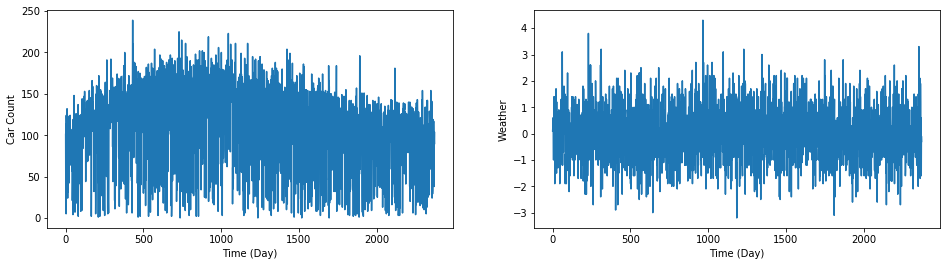

In [2]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(Data[outputVariables])
plt.ylabel('Car Count')
plt.xlabel('Time (Day)')

plt.subplot(1,2,2)
plt.plot(inputData['weather'])
plt.ylabel('Weather')
plt.xlabel('Time (Day)')


These two plots tell us that the car count data does not appear to be stationary, while the weather data does. To see this in a more quantitative fashion, we analyze the data using a multifractal method (see details in Agarwal et. al., PRSA, 2012). Below I plot the second moment of the fluctuation functions for the Car Count and the Weather data.

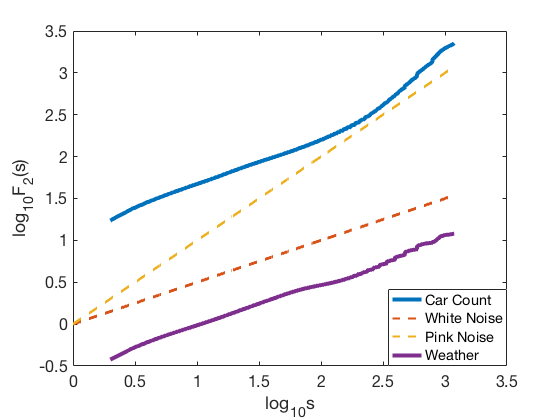

The slopes of the blue and purple curves denote the statistical dynamics for the car count and weather data, respectively. The dashed lines orange and yellow denote the white noise and pink noise, respectively. The slope of these fluctuation functions give us the dynamics, while the points where the slope changes are the dominant timescales in the data.

#### Car Count
It has a multifractal structure, with Gaussian white noise dynamics on timescales from a day to upto 200 days, and approximate pink noise dynamics on longer timescales. This tells us that given our problem for prediction of the next 30 days, a white noise structure might work.
#### Weather
It has a fractal structure, with white noise on all timescales.

Let us now visualze the correlation between the weather and the car count data.

Text(0,0.5,u'Car Count')

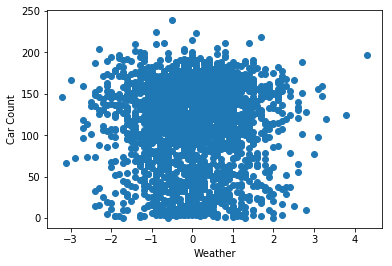

In [3]:
plt.figure()
plt.plot(inputData['weather'],Data[outputVariables],'o')
plt.xlabel('Weather')
plt.ylabel('Car Count')

Fitting a straight line (Linear Regression for Car Count vs Weather) through this gives us the following model:

Using normal equation formulation:

y = Car Count;
X = [1 Weather]; (1 is for the bias in the model)

w = inv(X' X) * (X'y);

/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


('Mean squared error:', 2571.086432938605)
('R-squared:', 4.9567129931316074e-05)


Text(10,240,u'y = [0.35034581]x + 112.77072187720019')

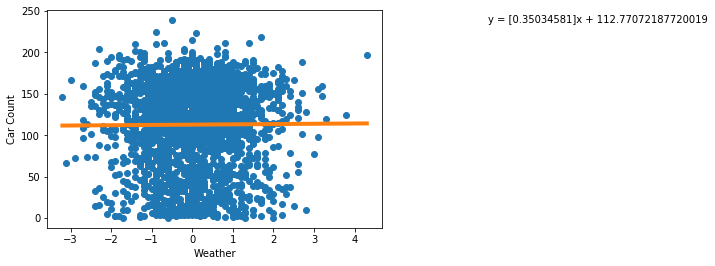

In [4]:
Y = Data[outputVariables]
Y = np.reshape(Y,(len(Y),1))
X = np.ones((len(inputData['weather']), 1))
C = inputData['weather']
C = np.reshape(C,(len(C),1))
X = np.concatenate((X, C), 1)

#w = (np.linalg.inv((X.T).dot(X))).dot(X.T).dot(Y) ## Normal Equation Form

model_1 = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
model_1.fit(C,Y)
c = model_1.intercept_[0]
w = model_1.coef_[0]
predicted = cross_val_predict(model_1, C, Y, cv=10)
print('Mean squared error:',np.mean((predicted - Y) ** 2))
print('R-squared:',model_1.score(C, Y))

plt.figure()
plt.plot(inputData['weather'],Data[outputVariables],'o')

x = np.linspace(min(C), max(C), 1000)
y = c + w * x
plt.plot(x, y, linewidth = 4)

plt.xlabel('Weather')
plt.ylabel('Car Count')
equation = 'y = ' + str(w) + 'x' ' + ' + str(c)
plt.text(10, 240,equation, horizontalalignment='center', verticalalignment='center')


This is a simple model and we see that the fit is not really great.

We need to use the information from the categorical variables and see how they affect the car count.

Given all the variables, we can possibly have the following dependencies:

1) Car Count depends on day of week

2) Car Count depends on the month of year (e.g. holiday season)

3) Car Count depends on sky conditions (Cloudy vs Clear)

4) Sky condition itself has a monthly dependence (as would be expected from the Earth climate sciences)

Before we check for the above dependencies, we need to modify the categorical variables to a numeric form. We parse the date first to compute the month of the year and replace the 'date' with the 'month'.

In [5]:
Date = inputData['date']
Month = Date.copy()
from dateutil.parser import parse
current = 0
while current < len(Date):
     temp = parse(Date[current])
     Month[current] = temp.month
     current += 1
        
Month.name = 'month'
inputData=inputData.join(Month)
del inputData['date']

We then change the categorical variables to dummy variables.

In [6]:
for column in inputData.columns:
 if inputData[column].dtype==object:
  dummyCols=pd.get_dummies(inputData[column])
  inputData=inputData.join(dummyCols)
  del inputData[column]

We first check the car count dependency on the day of the week, and plot the car count distributions for each day of the week. The variation in the distributions will tell us if the car count is correlated with the day of the week.

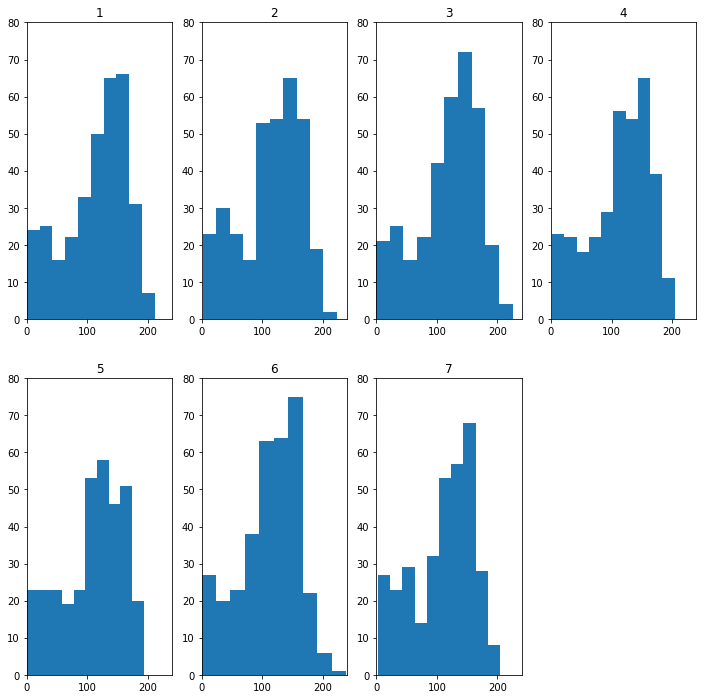

In [7]:
ID = np.asarray(inputData)
plt.figure(figsize=(12,12))
for i in range(1,8):
    A = ID[:,i]
    B = Y[A==1]
    plt.subplot(2,4,i)
    plt.hist(B)
    plt.axis([0, 240, 0, 80])
    plt.title((str(i)))


These histograms show that the distribution for all days of the week (1 = Friday, 2 = Monday, 3 = Saturday, 4 = Sunday, 5 = Thursday, 6 = Tuesday, 7 = Wednesday) are almost similar, with only very slight variations. Therefore, we ignore this dependency.

We now check the monthly dependencies, and plot the car count distributions for each month. As with the day of the week, the variation in these distributions will tell us if the car count is correlated with the month.

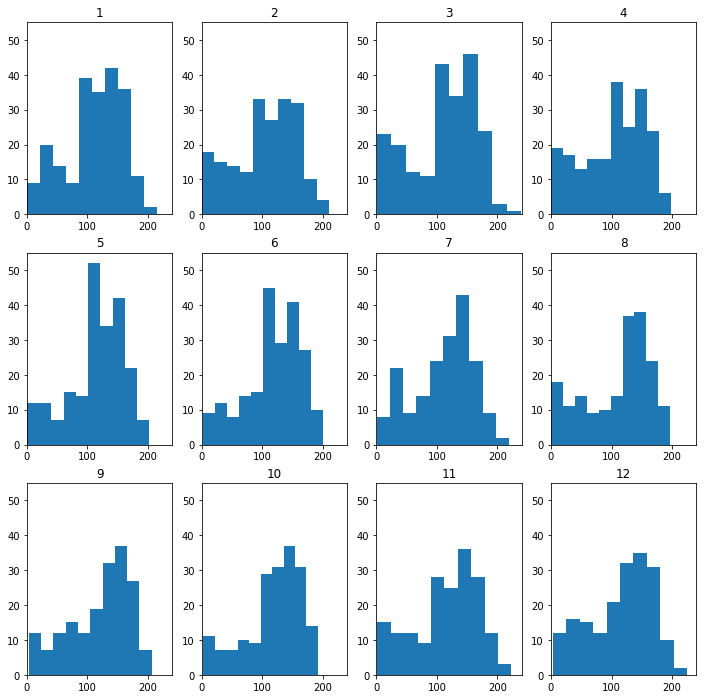

In [8]:
plt.figure(figsize=(12,12))
for i in range(1,13):
    A = inputData[i]
    B = Y[A==1]
    plt.subplot(3,4,i)
    plt.hist(B)
    plt.axis([0, 240, 0, 55])
    plt.title(str(i))
    

These histograms show that the distribution for all the months (1 = January...12 = December) are also similar, with small inter-month variations. We will discuss these variations later.

We now look at the last categorical variable in the data, the sky conditions (clear / cloudy).

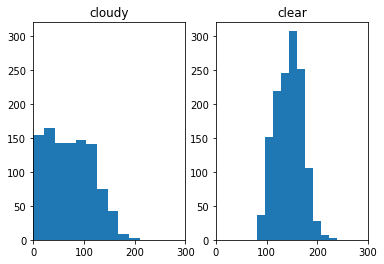

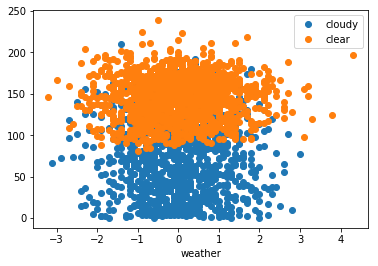

In [9]:
Clear = inputData['clear']
Weather = inputData['weather']
Weather_Cloudy = Weather[Clear==0]
Weather_Clear = Weather[Clear==1]
Car = Data[outputVariables]
Car_Cloudy = Car[Clear==0]
Car_Clear = Car[Clear==1]

plt.figure()
plt.subplot(1,2,1)
plt.hist(Car_Cloudy)
plt.axis([0, 300, 0, 320])
plt.title('cloudy')
plt.subplot(1,2,2)
plt.hist(Car_Clear)
plt.axis([0, 300, 0, 320])
plt.title('clear')

plt.figure()
plt.plot(Weather_Cloudy,Car_Cloudy,'o',label='cloudy')
plt.plot(Weather_Clear,Car_Clear,'o',label='clear')
plt.xlabel('weather')
plt.legend()

Here we see a clear distinction between the 'cloudy' and the 'clear' sky conditions. The car count in the parking lot is high when the sky is clear and relatively low when there are cloudy conditions (People like to go out when it is clear outside!!!). Therefore, we start with developing models for the car count with respect to sky conditions.

('Mean squared error (Cloudy):', 2003.747069882026)
('R-squared (Cloudy):', 0.0006483484044943477)
('Mean squared error (Clear):', 779.0753895432044)
('R-squared (Clear):', 0.0012723573633712792)
('Mean squared error (Total):', 1305.4829386142528)


Text(10,240,u'For Clear Skies: y = [0.91577103]x + 143.79697777000945')

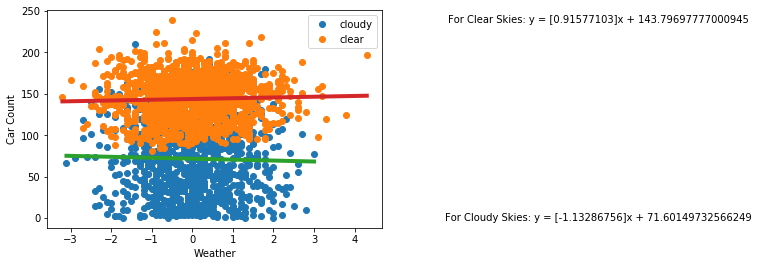

In [10]:
Weather_Cloudy = np.reshape(Weather_Cloudy,(len(Weather_Cloudy),1))
Car_Cloudy = np.reshape(Car_Cloudy,(len(Car_Cloudy),1))

model_1 = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
model_1.fit(Weather_Cloudy,Car_Cloudy)
c1 = model_1.intercept_[0]
w1 = model_1.coef_[0]
predicted_1 = cross_val_predict(model_1, Weather_Cloudy, Car_Cloudy, cv=10)
print('Mean squared error (Cloudy):',np.mean((predicted_1 - Car_Cloudy) ** 2))
print('R-squared (Cloudy):',model_1.score(Weather_Cloudy,Car_Cloudy))

Weather_Clear = np.reshape(Weather_Clear,(len(Weather_Clear),1))
Car_Clear = np.reshape(Car_Clear,(len(Car_Clear),1))

model_1 = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
model_1.fit(Weather_Clear,Car_Clear)
c2 = model_1.intercept_[0]
w2 = model_1.coef_[0]
predicted_2 = cross_val_predict(model_1, Weather_Clear, Car_Clear, cv=10)
print('Mean squared error (Clear):',np.mean((predicted_2 - Car_Clear) ** 2))
print('R-squared (Clear):',model_1.score(Weather_Clear, Car_Clear))

print('Mean squared error (Total):',(np.add(np.sum((predicted_2 - Car_Clear) ** 2), np.sum((predicted_1 - Car_Cloudy) ** 2)))/(len(predicted_1)+len(predicted_2)))

plt.figure()
plt.plot(Weather_Cloudy,Car_Cloudy,'o',label='cloudy')
plt.plot(Weather_Clear,Car_Clear,'o',label='clear')
plt.xlabel('weather')
plt.legend()
x = np.linspace(min(Weather_Cloudy), max(Weather_Cloudy), 1000)
y = c1 + w1 * x
plt.plot(x, y, linewidth = 4)
x = np.linspace(min(Weather_Clear), max(Weather_Clear), 1000)
y = c2 + w2 * x
plt.plot(x, y, linewidth = 4)
plt.xlabel('Weather')
plt.ylabel('Car Count')
equation = 'For Cloudy Skies: y = ' + str(w1) + 'x' ' + ' + str(c1)
plt.text(10, 0,equation, horizontalalignment='center',
     verticalalignment='center')
equation = 'For Clear Skies: y = ' + str(w2) + 'x' ' + ' + str(c2)
plt.text(10, 240,equation, horizontalalignment='center',
     verticalalignment='center')

The plot above clearly shows that the car count is high for clear skies compared to the cloudy conditions, with the  model having a 'positive' slope and a high intercept for the clear sky conditions and 'negative' slope and a relatively low intercept for the cloudy sky conditions. The combined Mean Squared Error of the two models is also considerable lower than before where we had separated sky conditions.

We would now like to investigate if the weather index and the sky conditions are somehow related, for which we look at the cross-correlation coefficients between the respective data.

Text(0.5,0,u'Lag')

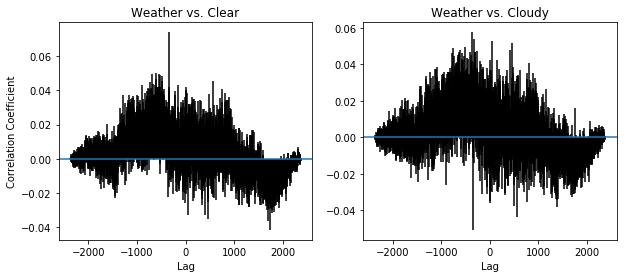

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xcorr(ID[:,0],ID[:,8],maxlags=None)
plt.title('Weather vs. Clear')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag')

plt.subplot(1,2,2)
plt.xcorr(ID[:,0],ID[:,9],maxlags=None)
plt.title('Weather vs. Cloudy')
plt.xlabel('Lag')

The two plots above show that the weather index and the sky conditions have really low correlations (if at all). Just to reconfirm our hypothesis that the car count in the parking lot is correlated with the sky conditions, we also plot the cross-correlation coefficients between the car count and clear sky conditions, and see that it supports our argument.

Text(0.5,0,u'Lag')

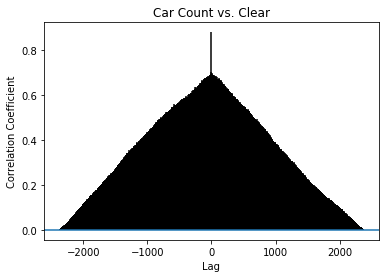

In [12]:
plt.xcorr(Data[outputVariables],ID[:,8],maxlags=None)
plt.title('Car Count vs. Clear')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag')

### Naive Bayes

Given that the maximum correlation exists between the car count and tke sky conditions, we will compute the fraction of 'clear' days in a given month, using the Bayes Rule, as follows:

P(clear|Month) = P(Month|clear) * P(clear) / P(Month)

[[-0.09358697 -0.02875901  0.23020167  0.01252021 -0.08162549]]
[[-0.04438053 -0.02458552  0.15663643  0.01096261 -0.05966802]]


Text(0,0.5,u'Clear Days Fraction')

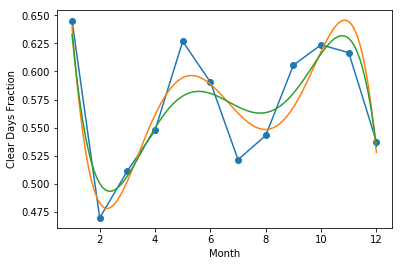

In [13]:
Cp = np.zeros((12,1))
Clr = ID[:,8]
for i in range(1,13):
    A = ID[:,i+9]
    B  = Clr[A==1]
    Cp[i-1] = float(len(np.where(B==1)[0]))/len(B) ## Computing P(clear|Month)
    
x = np.arange(1,13)
x = np.reshape((x - np.mean(x))/np.std(x),(len(x),1)) # Scaling the independent variable (Month Index)
x = np.concatenate((x,x**2,x**3,x**4,x**5),1)
model_1=linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1) # Ordinary Linear Regression
model_2=linear_model.Ridge(alpha=0.1,fit_intercept=True, normalize=False, copy_X=True) # Using L2 Regularization
model_1.fit(x,Cp)
model_2.fit(x,Cp)

print model_1.coef_
print model_2.coef_

p1 = model_1.coef_[0]
c1 = model_1.intercept_

p2 = model_2.coef_[0]
c2 = model_2.intercept_

x = np.arange(1,12.1,0.1)
x2 = (x - np.mean(range(1,13)))/np.std(range(1,13))
y1 = x2**5 * p1[4] + x2**4 * p1[3] + x2**3 * p1[2] + x2**2 * p1[1] + x2 * p1[0] + c1
y2 = x2**5 * p2[4] + x2**4 * p2[3] + x2**3 * p2[2] + x2**2 * p2[1] + x2 * p2[0] + c2
    
plt.plot(range(1,13),Cp,'-o')
plt.plot(x,y1)
plt.plot(x,y2)
plt.xlabel('Month')
plt.ylabel('Clear Days Fraction')


Above, we fitted the monthly variation in the clear day fraction using Ordinary Least Squares, without and with L2 regularization by a 5th order polynomial to look at the inter-month variations.

We can use the computed P(clear|Month) values as a scaling between the clear and cloudy sky conditions, for each month as described below.

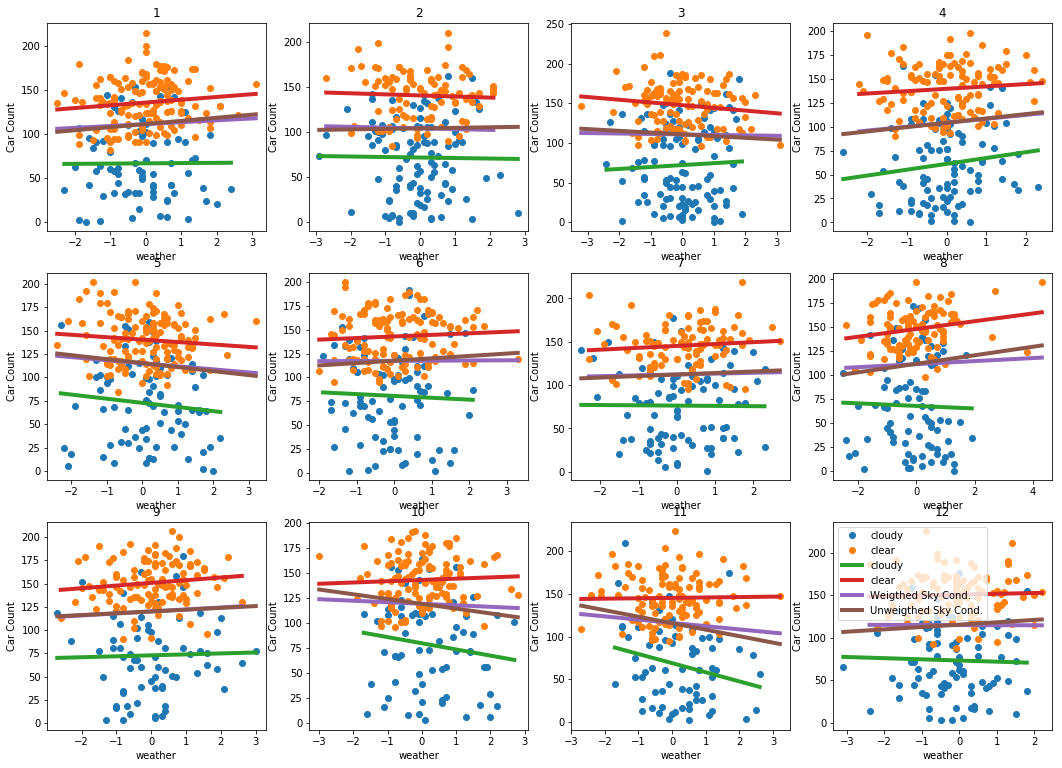

In [14]:
model_1=linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
P = np.zeros((5,1))
plt.figure(figsize=(18,13))
Clr = inputData['clear']
Cnt = Data[outputVariables]
Wtr = inputData['weather']
for i in range(1,13):
    A = inputData[i]
    Ct = Cnt[A==1]
    Wt = Wtr[A==1]
    Cl = Clr[A==1]
    B = np.reshape(Wt[Cl==0],(len(Wt[Cl==0]),1))
    C = np.reshape(Ct[Cl==0],(len(Ct[Cl==0]),1))
    model_1.fit(B,C)
    x1 = np.linspace(min(B), max(B), 1000)
    y1 = model_1.intercept_ + model_1.coef_[0] * x1
    P[0] = model_1.coef_[0]
    P[1] = model_1.intercept_
    D = np.reshape(Wt[Cl==1],(len(Wt[Cl==1]),1))
    E = np.reshape(Ct[Cl==1],(len(Ct[Cl==1]),1))
    model_1.fit(D,E)
    x2 = np.linspace(min(D), max(D), 1000)
    y2 = model_1.intercept_ + model_1.coef_[0] * x2
    P[2] = model_1.coef_[0]
    P[3] = model_1.intercept_
    
    model_1.fit(np.reshape(Wt,(len(Wt),1)),np.reshape(Ct,(len(Ct),1)))
    x3 = np.linspace(min(Wt), max(Wt), 1000)
    y3 = model_1.intercept_ + model_1.coef_[0] * x3
    
    plt.subplot(3,4,i)
    plt.plot(B,C,'o',label='cloudy')
    plt.plot(D,E,'o',label='clear')
    plt.plot(x1, y1, linewidth = 4,label='cloudy')
    plt.plot(x2, y2, linewidth = 4,label='clear')
    plt.ylabel('Car Count')
    plt.xlabel('weather')
    plt.title(str(i))

    x2 = np.linspace(min(D), max(D), 1000)
    P[4] = Cp[i-1]  # Using the clear day fraction for a given month to scale the two separate models
    y = (P[4]*P[3] + (1-P[4])*P[1]) + (P[4]*P[2] + (1-P[4])*P[0]) * x2
    plt.plot(x2, y, linewidth = 4,label='Weigthed Sky Cond.')
    plt.plot(x3, y3, linewidth = 4,label='Unweigthed Sky Cond.')

plt.legend()

The plots above for each month, while displaying a lot of variation, do not necessarily capture the complete dynamics / variance of the given dataset.

## Probabilistic Models

We know there exists a high correlation between the sky conditions and the car count in the parking lot. To start with this, we can bulid Gaussian probabilistic models, based on P(clear|Month) as computed above and the distribution of car counts for a given month and given sky condition.

#### Model 1
For a given month we use the P(clear|Month) computed above, and then based on that, sample the car counts. As a first step in this model, we need to check if the distribution of car counts for a given month and a given sky condition has Gaussian structure. Lets try this below:

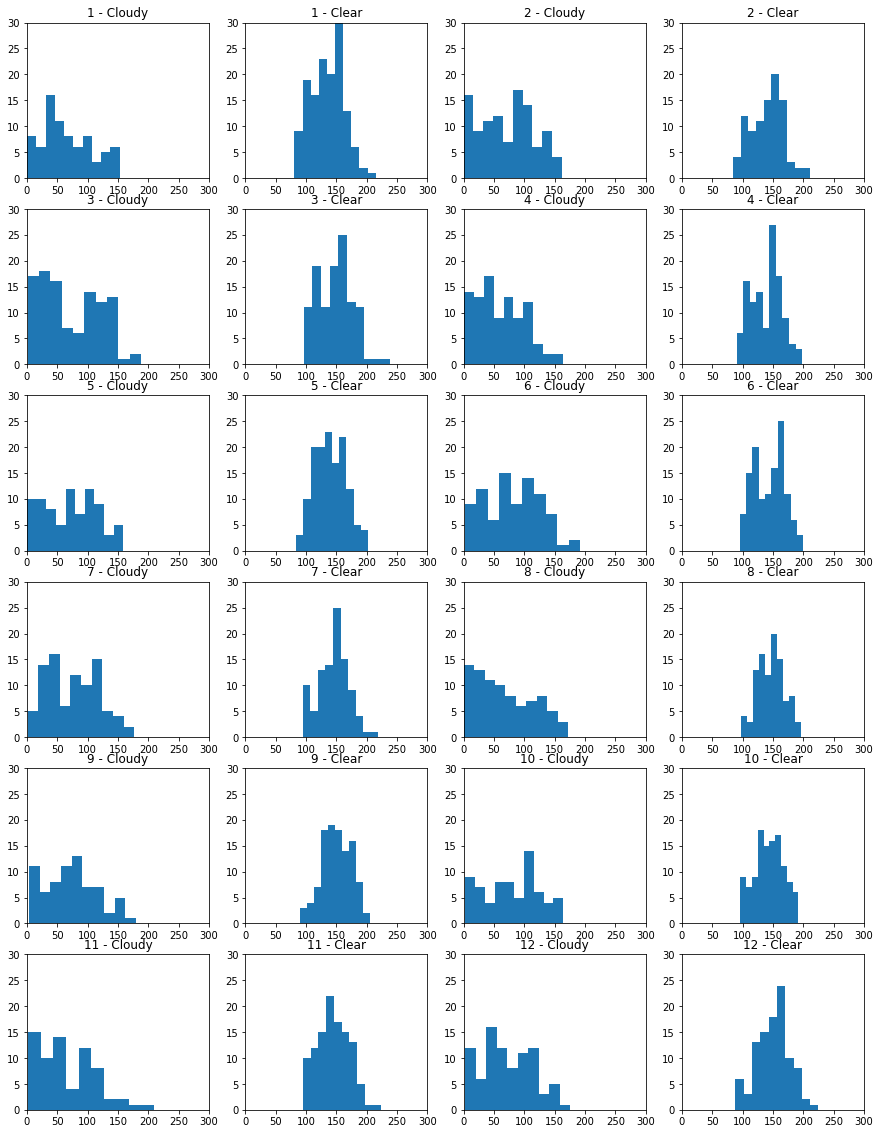

In [15]:
Clr = inputData['clear']
Cnt = Data[outputVariables]
Wtr = inputData['weather']

plt.figure(figsize=(15,20))
for i in range(1,13):
    A = inputData[i]
    Ct = Cnt[A==1]
    Wt = Wtr[A==1]
    Cl = Clr[A==1]
    C = np.reshape(Ct[Cl==0],(len(Ct[Cl==0]),1))
    E = np.reshape(Ct[Cl==1],(len(Ct[Cl==1]),1))
    
    plt.subplot(6,4,2*i-1)
    plt.hist(C)
    plt.axis([0, 300, 0, 30])
    plt.title(str(i) + ' - Cloudy')
    plt.subplot(6,4,2*i)
    plt.hist(E)
    plt.axis([0, 300, 0, 30])
    plt.title(str(i) + ' - Clear')

While the histograms for the car count on clear days has an approximate Gaussian structure (bell shaped), that for cloudy days does not. Therefore, we append the cloudy day data with its negative self, which should then give us an approximate bell curve, as shown below.

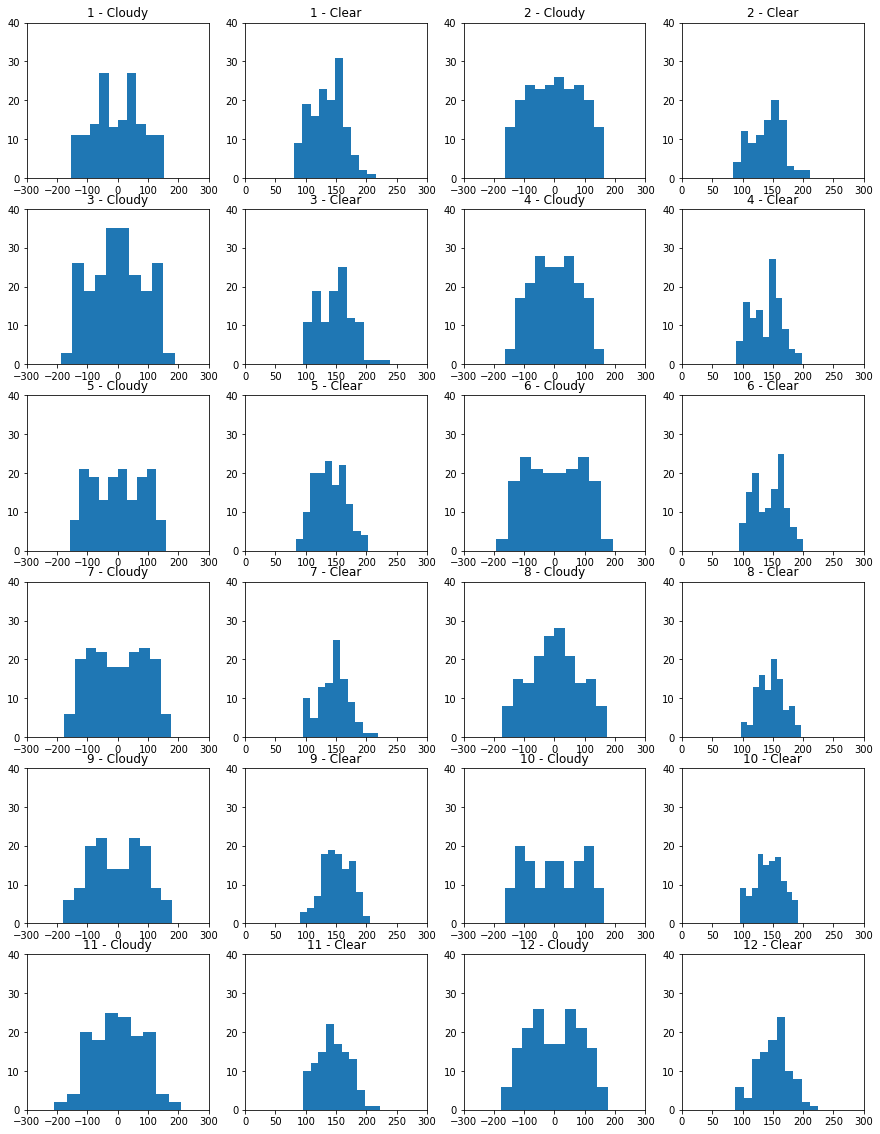

In [16]:
Clr = inputData['clear']
Cnt = Data[outputVariables]
Wtr = inputData['weather']

plt.figure(figsize=(15,20))
for i in range(1,13):
    A = inputData[i]
    Ct = Cnt[A==1]
    Wt = Wtr[A==1]
    Cl = Clr[A==1]
    C = np.reshape(Ct[Cl==0],(len(Ct[Cl==0]),1))
    C = np.concatenate((C,np.multiply(C,-1)))
    E = np.reshape(Ct[Cl==1],(len(Ct[Cl==1]),1))
    
    plt.subplot(6,4,2*i-1)
    plt.hist(C)
    plt.axis([-300, 300, 0, 40])
    plt.title(str(i) + ' - Cloudy')
    plt.subplot(6,4,2*i)
    plt.hist(E)
    plt.axis([0, 300, 0, 40])
    plt.title(str(i) + ' - Clear')

Now that the Car Count distributions are approximate Gaussians for each month and sky condition, we can move to the next step and build our first model as follows:

1) For each month the number of clear days is P(clear|Month)* (Number of Days in that Month)

2) For each clear / cloudy day in that month, sample from the corresponding car count distribution.

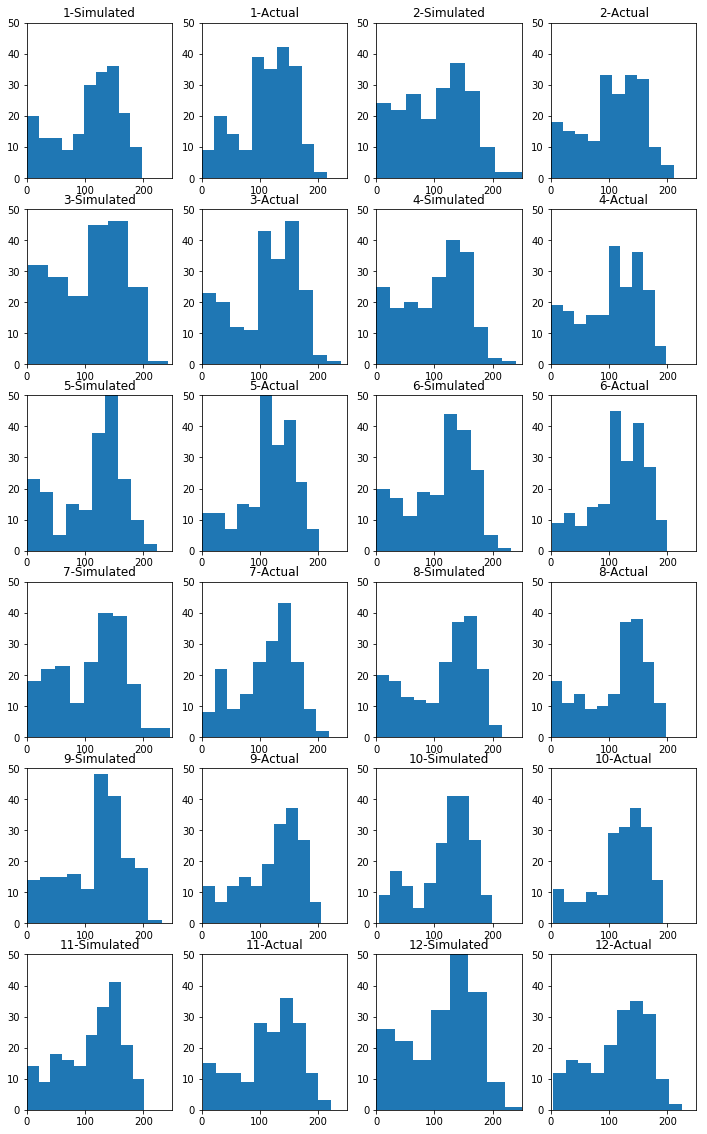

In [17]:
meanCnt = np.zeros((12,2))
stdCnt = np.zeros((12,2))
Clr = inputData['clear']
Cnt = Data[outputVariables]
Wtr = inputData['weather']
MonthDay = [31,28,31,30,31,30,31,31,30,31,30,31] # Actual Days in a month
MonthDay = [200,200,200,200,200,200,200,200,200,200,200,200] # To produce distribution
plt.figure(figsize=(12,20))
np.random.seed(1)
for i in range(1,13):
    A = inputData[i]
    Ct = Cnt[A==1]
    Wt = Wtr[A==1]
    Cl = Clr[A==1]
    C = np.reshape(Ct[Cl==0],(len(Ct[Cl==0]),1))
    C = np.concatenate((C,np.multiply(C,-1)))
    E = np.reshape(Ct[Cl==1],(len(Ct[Cl==1]),1))
    
    meanCnt[i-1,0] = np.nanmean(C)
    stdCnt[i-1,0] = np.nanstd(C)
    meanCnt[i-1,1] = np.nanmean(E)
    stdCnt[i-1,1] = np.nanstd(E)

    Cnts = np.zeros((MonthDay[i-1],1))
    clearDays = np.floor(Cp[i-1] * MonthDay[i-1])
    Cnts[0:int(clearDays)] = np.floor(abs((np.random.normal(meanCnt[i-1,1],stdCnt[i-1,1],(int(clearDays),1)))))
    Cnts[int(clearDays):MonthDay[i-1]] = np.floor(abs(np.random.normal(meanCnt[i-1,0],stdCnt[i-1,0],(int(MonthDay[i-1]-clearDays),1))))
    plt.subplot(6,4,2*i-1)
    plt.hist(Cnts)
    plt.title(str(i) + '-Simulated')
    plt.axis([0, 250, 0, 50])
    plt.subplot(6,4,2*i)
    plt.hist(Ct)
    plt.title(str(i) + '-Actual')
    plt.axis([0, 250, 0, 50])

#### Model 2

1) For each month, instead of using a fixed P(clear|Month), sample the P(clear|Month) from the given distribution of P(clear|Month) for each month of the record and then probabilistically compute the number of clear days in that month.

2) For each clear / cloudy day in that month, sample from the corresponding car count distribution.

We first compute the distribution of P(clear|Month) below:

Text(0.5,0,u'Month')

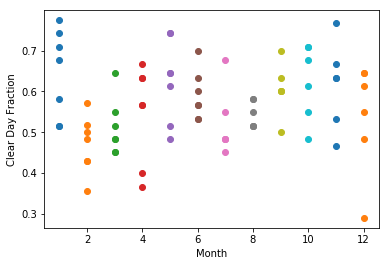

In [18]:
D = np.zeros((7,12))
for i in range(10,22):
    A = ID[:,i]
    J = np.where((np.ediff1d(A))>0)[0]
    D[0:len(J),i-10] = J
    
D[1:7,0] = D[0:6,0]
D[0,0] = -1

M = np.zeros((7,12))
for i in range(0,7):
    for j in range(0,11):
        if D[i,j+1] != 0:
            J = ID[range(int(D[i,j])+1,int(D[i,j+1])+1),8];
            M[i,j] = float(len(np.where(J==1)[0]))/len(J);

for i in range(0,6):
    J = ID[range(int(D[i,11])+1,int(D[i+1,0])+1),8];
    M[i,11] = float(len(np.where(J==1)[0]))/len(J);

J = ID[range(2343,2373),8]
M[6,5] = float(len(np.where(J==1)[0]))/len(J);

M1 = np.reshape(range(1,13),(12,1))
M1 = (np.concatenate((M1,M1,M1,M1,M1,M1,M1),1)).T

M[6,6:12] = float('nan')

plt.figure()
plt.plot(M1,M,'o')
plt.ylabel('Clear Day Fraction')
plt.xlabel('Month')

We see that there is a huge inter-annual as well as inter-month variation for the clear day fraction. We will now sample from this given distribution for each month for P(clear|month) and then continue as before to sample from the clear / cloudy distribution.

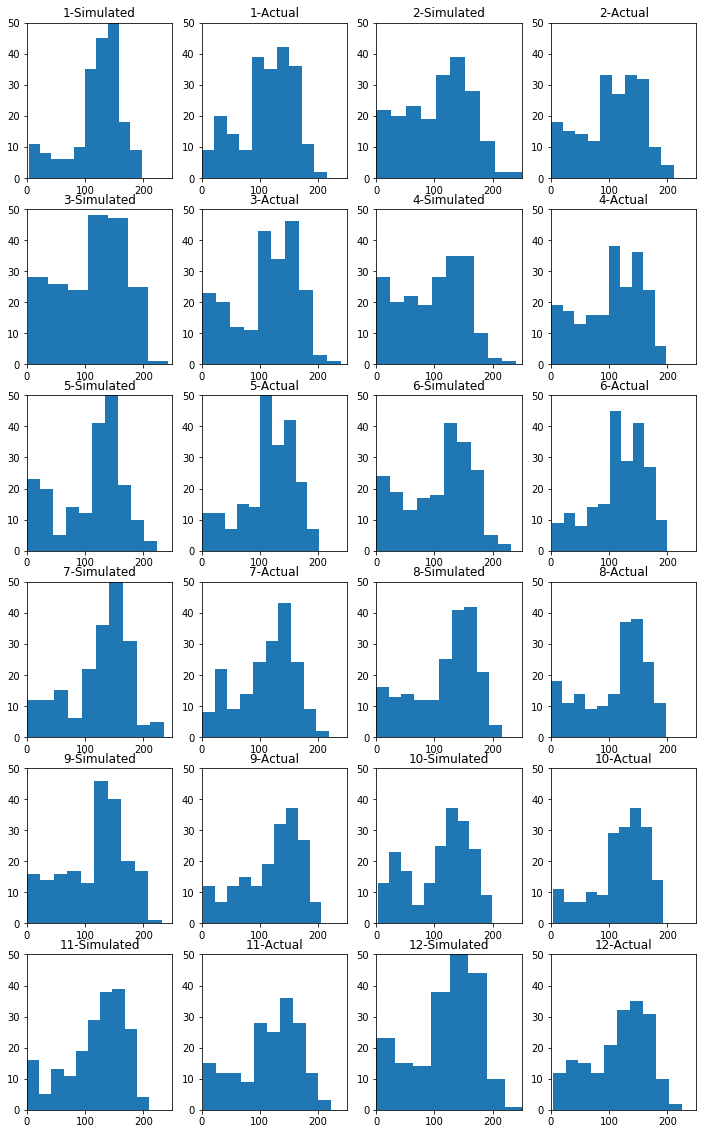

In [19]:
meanClear = np.zeros((12,1))
stdClear = np.zeros((12,1))
meanCnt = np.zeros((12,2))
stdCnt = np.zeros((12,2))
Clr = inputData['clear']
Cnt = Data[outputVariables]
Wtr = inputData['weather']
MonthDay = [31,28,31,30,31,30,31,31,30,31,30,31] # Actual Days in a month
MonthDay = [200,200,200,200,200,200,200,200,200,200,200,200] # To produce distribution
np.random.seed(1)
plt.figure(figsize=(12,20))
for i in range(1,13):
    A = inputData[i]
    Ct = Cnt[A==1]
    Wt = Wtr[A==1]
    Cl = Clr[A==1]
    C = np.reshape(Ct[Cl==0],(len(Ct[Cl==0]),1))
    C = np.concatenate((C,np.multiply(C,-1)))
    E = np.reshape(Ct[Cl==1],(len(Ct[Cl==1]),1))
    
    meanClear[i-1] = np.nanmean(M[:,i-1])
    stdClear[i-1] = np.nanstd(M[:,i-1])
    meanCnt[i-1,0] = np.nanmean(C)
    stdCnt[i-1,0] = np.nanstd(C)
    meanCnt[i-1,1] = np.nanmean(E)
    stdCnt[i-1,1] = np.nanstd(E)

    Cnts = np.zeros((MonthDay[i-1],1))
    clearDays = np.floor(np.random.normal(meanClear[i-1],stdClear[i-1]) * MonthDay[i-1])
    Cnts[0:int(clearDays)] = np.floor(abs((np.random.normal(meanCnt[i-1,1],stdCnt[i-1,1],(int(clearDays),1)))))
    Cnts[int(clearDays):MonthDay[i-1]] = np.floor(abs(np.random.normal(meanCnt[i-1,0],stdCnt[i-1,0],(int(MonthDay[i-1]-clearDays),1))))
    plt.subplot(6,4,2*i-1)
    plt.hist(Cnts)
    plt.axis([0, 250, 0, 50])
    plt.title(str(i) + '-Simulated')
    plt.subplot(6,4,2*i)
    plt.hist(Ct)
    plt.axis([0, 250, 0, 50])
    plt.title(str(i) + '-Actual')

## Markov Chain for Sky Condition
We can now move to even more complex models, where similar to a Recurrent Neural Network, we build a Markov Chain for the sky condition using the transition probabilities from the given data, and then sample the car count from the complete clear / cloudy condition.

541 812 540 479
0.39985218034 0.60014781966 0.529931305201 0.470068694799


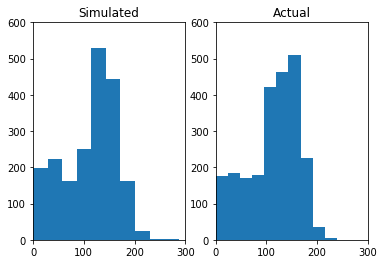

In [20]:
Clr = ID[:,8]
#### 1 = clear, 0 = cloudy; p11 = clear->clear, p10 = clear->cloudy, p01 = cloudy->clear, p00 = cloudy->cloudy
p10,p11,p01,p00 = 0,0,0,0
for i in range(0,ID.shape[0]-1):
    if Clr[i]==1 and Clr[i+1]==1:
        p11 = p11+1;
    elif Clr[i]==1 and Clr[i+1]==0:
        p10 = p10+1;
    elif Clr[i]==0 and Clr[i+1]==1:
        p01 = p01+1;
    elif Clr[i]==0 and Clr[i+1]==0:
        p00 = p00+1;

# Transition Probabilities        
P11 = float(p11)/(p11+p10)
P10 = float(p10)/(p11+p10)
P01 = float(p01)/(p01+p00)
P00 = float(p00)/(p01+p00)
        
print p10,p11,p01,p00        
print P10,P11,P01,P00       

A = inputData['clear']
C = Data[outputVariables]
E = C[A==1]
C = C[A==0]
C = np.concatenate((C,np.multiply(C,-1)))

PDF = np.zeros((2,2))

PDF[0,0] = np.nanmean(C)
PDF[0,1] = np.nanmean(E)
PDF[1,0] = np.nanstd(C)
PDF[1,1] = np.nanstd(E)

T = 2000 # Number of Days to simulate
Cr_Cy = np.zeros((T,1)) # Sky Condition
MC_Cnt = np.zeros((T,1)) # Corresponding Car Count
Cr_Cy[0] = ID[-1,8] # Initial Sky Condition as the last data point given to us

Cnt = Data[outputVariables]
Cnt = np.reshape(Cnt,(len(Cnt),1))

MC_Cnt[0] = Cnt[-1] # Last car count data point given to us

for i in range(1,T):
    a = np.random.uniform()
    if Cr_Cy[i-1]==1 and a < P11:
        Cr_Cy[i] = 1
        MC_Cnt[i] = np.floor(abs((np.random.normal(PDF[0,1],PDF[1,1]))))    
    elif Cr_Cy[i-1]==1 and a > P11:
        Cr_Cy[i] = 0
        MC_Cnt[i] = np.floor(abs((np.random.normal(PDF[0,0],PDF[1,0]))))    
    if Cr_Cy[i-1]==0 and a < P00:
        Cr_Cy[i] = 0
        MC_Cnt[i] = np.floor(abs((np.random.normal(PDF[0,0],PDF[1,0]))))    
    if Cr_Cy[i-1]==0 and a > P00:
        Cr_Cy[i] = 1
        MC_Cnt[i] = np.floor(abs((np.random.normal(PDF[0,1],PDF[1,1]))))    
    
    
        
#plt.figure()
#plt.plot(Cr_Cy)

#plt.figure()
#plt.plot(MC_Cnt)

plt.figure()
plt.subplot(1,2,1)
plt.hist(MC_Cnt)
plt.title('Simulated')
plt.axis([0, 300, 0, 600])
plt.subplot(1,2,2)
plt.hist(Cnt)
plt.title('Actual')
plt.axis([0, 300, 0, 600])

df = pd.DataFrame(MC_Cnt)
df.to_csv('Next_'+str(T)+'_days.csv') # Continuous Days 

This Markov Chain model gives an excellent fit to the statistical characteristics of the actual data, and therefore can be used to predict the next 30 days (change T in above code).

The actual car count had a non-stationary structure, with a increasing trend first and then a decreasing trend. The above model does not capture that but since we only need to predict for the next month, the effect of trend can be ignored up to 1st order.

Next, instead of computing the annual transition probabilities, we do it monthwise:

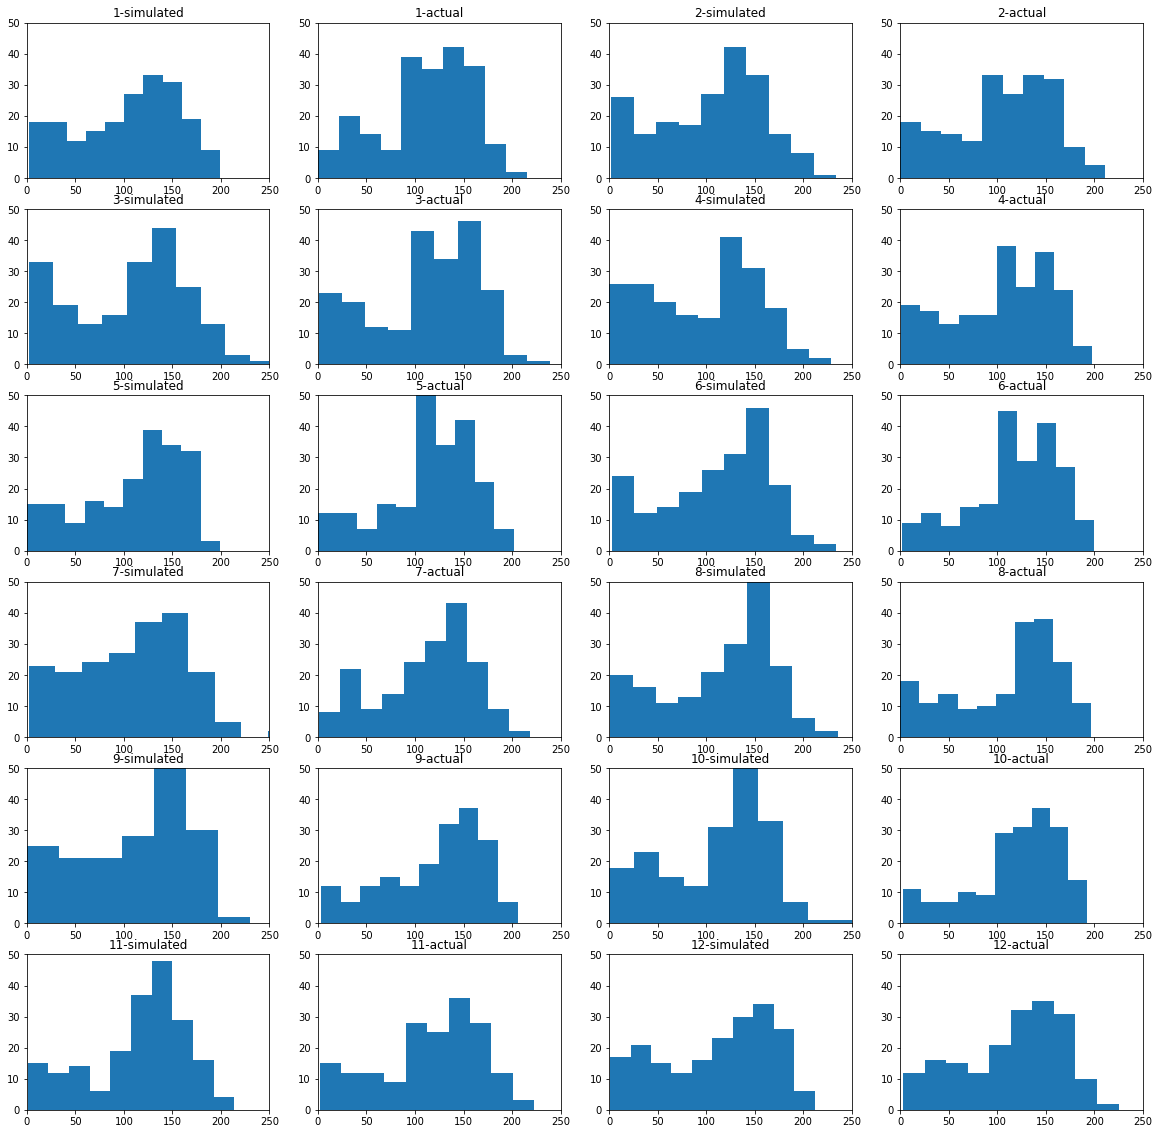

In [21]:
Clr = ID[:,8]
#### 1 = clear, 0 = cloudy; p11 = clear->clear, p10 = clear->cloudy, p01 = cloudy->clear, p00 = cloudy->cloudy
P = np.zeros((12,4))
A = inputData['clear']
Cnt = Data[outputVariables]
PDF = np.zeros((12,4))
MonthDay = [31,28,31,30,31,30,31,31,30,31,30,31]
MonthDay = [200,200,200,200,200,200,200,200,200,200,200,200]
Cr_Cy = np.zeros((12,200))
MC_Cnt = np.zeros((12,200))
plt.figure(figsize=(20,20))

for j in range(1,13):
    Month = inputData[j]
    Car = np.reshape(Cnt[Month==1],(len(Cnt[Month==1]),1))
    p10,p11,p01,p00 = 0,0,0,0
    Month = np.reshape(Clr[Month==1],(len(Clr[Month==1]),1))
    for i in range(0,len(Month)-1):
        if Month[i]==1 and Month[i+1]==1:
            p11 = p11+1;
        elif Month[i]==1 and Month[i+1]==0:
            p10 = p10+1;
        elif Month[i]==0 and Month[i+1]==1:
            p01 = p01+1;
        elif Month[i]==0 and Month[i+1]==0:
            p00 = p00+1;

    P[j-1,0] = float(p11)/(p11+p10)
    P[j-1,1] = float(p10)/(p11+p10)
    P[j-1,2] = float(p01)/(p01+p00)
    P[j-1,3] = float(p00)/(p01+p00)

    #print Month.shape
    #print Car.shape
    
    E = Car[Month==1]
    C = Car[Month==0]
    C = np.concatenate((C,np.multiply(C,-1)))

    PDF[j-1,0] = np.nanmean(C)
    PDF[j-1,1] = np.nanmean(E)
    PDF[j-1,2] = np.nanstd(C)
    PDF[j-1,3] = np.nanstd(E)
    
    

    T = MonthDay[j-1]
    Cr_Cy[j-1,0] = Month[-1]

    #C = np.reshape(Car[Month==1],(len(Car[Month==1]),1))

    MC_Cnt[j-1,0] = Car[-1]

    for i in range(1,T):
        a = np.random.uniform()
        if Cr_Cy[j-1,i-1]==1 and a < P[j-1,0]:
            Cr_Cy[j-1,i] = 1
            MC_Cnt[j-1,i] = np.floor(abs((np.random.normal(PDF[j-1,1],PDF[j-1,3]))))    
        elif Cr_Cy[j-1,i-1]==1 and a > P[j-1,0]:
            Cr_Cy[j-1,i] = 0
            MC_Cnt[j-1,i] = np.floor(abs((np.random.normal(PDF[j-1,0],PDF[j-1,2]))))    
        if Cr_Cy[j-1,i-1]==0 and a < P[j-1,3]:
            Cr_Cy[j-1,i] = 0
            MC_Cnt[j-1,i] = np.floor(abs((np.random.normal(PDF[j-1,0],PDF[j-1,2]))))    
        if Cr_Cy[j-1,i-1]==0 and a > P[j-1,3]:
            Cr_Cy[j-1,i] = 1
            MC_Cnt[j-1,i] = np.floor(abs((np.random.normal(PDF[j-1,1],PDF[j-1,3]))))    
    
#plt.figure()
#plt.plot(Cr_Cy)

#plt.figure()
#plt.plot(MC_Cnt)

    plt.subplot(6,4,2*j-1)
    plt.hist(MC_Cnt[j-1,:])
    plt.title(str(j) + '-simulated')
    plt.axis([0, 250, 0, 50])
    plt.subplot(6,4,2*j)
    plt.hist(Car)
    plt.title(str(j) + '-actual')
    plt.axis([0, 250, 0, 50])
    
df = pd.DataFrame(MC_Cnt.T)
df.to_csv('Next_'+str(200)+'_days_Month.csv') # 0 - January ----> 11 - December

Even this model produces good statistics and can be used for prediction of car count for any given month.

# Results

The first step is to identify the independent variables. The dependent variable is the Car Count, but how does it depend on other variables!!

To answer this question, we looked at the correlations between different independent (numerical and categorical variables) and the car count. 

1) I started with visualization and a linear regression model for the car count and weather index. No clear dependency between the value of the weather index and the car count was apparent.

2) I then studied if the car count varied with the day of the week. To do this we looked at the distribution of the car count for each day of the week for the complete record. These distributions showed that only slighest of dependencies (if any) exist and therefore we ignore this variable in future models.

3) Next I examined the correlation between the month of the year and the car count, and again utilized the distributions of the car count with respect to the month. These distribution had slight variations.

4) Lastly, I looked at how the car count in the parking lot varies with the sky conditions. Both simple data visualization and histrograms showed a high correlation between the car count and the sky condition. Clear sky led to more cars, while cloudy skies led to a decrease in the car count. I developed two separate linear models for clear / cloudy skies, and saw that the combined mean squared error was lower than for the single model.

5) I then verified the correlation between the weather index and the sky conditions to see if they were related, but found otherwise, while the the car count was highly correlated with the sky conditions supported by the cross-correlation function.

6) Using the Bayes Rule, I then computed the clear days fraction in any given month. Then for each month, I developed two separate models for clear / cloudy skies, and then using the clear day fraction, scaled them. This scaled model was similar to using just one model without any regard to the sky conditions. 

7) Since the only correlation being observed was between the car count and sky conditions, I then moved to probabilistic models. Using the clear day fraction for a given month computed in the previous step, I first computed the clear days and cloudy days in a month and then sampled the car count from its distribution for that month and sky condition. To perform this, I had to first modify the "cloudy" distribution to make it Gaussian. This sampling provided a better model than the linear models above, but there is no interannual variation.

8) To account for the interannual variation, I now also sample the clear day fraction from the clear day fraction for each month and year. And then proceed as before to compute the total clear days in a month and then sampling from the respective distribution. This model also has good statistics and can be used for prediction when one is only interesed in the distribution of car counts in a month, and not the day-to-day variation.

9) To add complexity towards day-to-day variation, I built a Markov Chain model, similar to a Recurrent Neural Network, where I computed the transition probabilities for the sky conditions. Then combining a simulation of this Markov Chain model with the sampling of car count from the complete car count distribution w.r.t. sky conditions (ignoring the month), gave a good enough match between the observed and the simulated car count distribution. This gives a prediction for any number of continuous days in a year.

10) Lastly, I modified the previous model to make it dependent on the month and computed the transition probabilities separately for each month. This gives us a prediction for any number of days for a given month.


## Future Work
1) I used the complete data set for training the Markov chain models, but given more time, it can be trained iteratively starting from a smaller training set and increasing its size and checking for errors.

2) Markov chain models only look at the previous state. Since we know that there is a long term trend in the data, the Markov Chain model cannon capture it. To do this we can build more complex models that also than into account long time memory.

3) The transition probabilities in the Markov Chain models can be updated with each time step of prediction, rather than fixed probabilities.

4) The two Markov Chain models have different dynamics: the first ignores the monthly dependencies, while the second does not take into account the continuity of probabilities between different months. A more complex model can be generated as some combination of these two, where both the monthly dependencies and continuity exist.